## Convergence Bispectrum Calculations

In [2]:
import numpy as np
import healpy as hp
import bispec_calculator as bispec
from helper_funcs import *

The goal of this Jupyter notebook is to calculate the Theoretical Convergence Bispectrum, which is given by $\texttt{Munshi et. al}$'s paper as the equation

$$B_{\ell_1, \ell_2, \ell_3} = \int_0^{\chi_s} d\chi \left[\frac{3\Omega_M H_0^2}{2a(\chi)}\right]^3 \chi^2 W^3(\chi, \chi_s) B_{\delta}\left(\frac{\ell_1}{\chi}, \frac{\ell_2}{\chi}, \frac{\ell_3}{\chi}, \chi\right)$$

Since the source plan is just the CMB plane here, then we can find the comoving distance by converting the redshift of the CMB plane to comoving distance:

In [3]:
from scipy.integrate import quad
from scipy import interpolate
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import c
from astropy import units as u

def interp_chi_and_z(z: int) -> float:
    """
    Interpolate comoving and redshift

    Parameters:
        z (int) : redshift
    
    Returns:
        chi_from_z (float) : comoving distance
    """
    c_km = c.to(u.km/u.s).value

    def _invH(z):
        return c_km/cosmo.H(z).value

    zs = np.logspace(-2, 3.5, 1000)
    dcm = np.zeros_like(zs)

    for i, z in enumerate(zs):
        dcm[i] = quad(_invH, 0, z)[0]

    chi_int = interpolate.interp1d(zs, dcm, bounds_error=False, fill_value = 0)
    z_int = interpolate.interp1d(dcm, zs, bounds_error=False, fill_value = 0)

    return chi_int, z_int

In [4]:
chi_int = interp_chi_and_z(5)[0]

In [5]:
chi_int(0.4)

array(1600.12854886)

In [6]:
def compute_scale_factor(z: int) -> float:
    """
    Finds the scale factor a(z) from z.

    Parameters:
        z (int) : redshift

    Returns:
        a (float) : scale factor
    """
    return 1 / (1 + z)

Create $P_k$ as a function of $k$ and $z$ and create a 2-d interpolation.

To Do:
- Check how long `create_pk` takes to call.
- CAMB Matter Power Interpolator
    - Check to make sure that I'm putting the right Cosmology in
    - Check units after?
    - Based on RectBivariateSpline

*Dimensionaless vs. Dimensional $P(k)$ units, check to make sure that these factors are/aren't there before integration*

Div0 Question:
- Start from 0.01

In [7]:
from camb import get_matter_power_interpolator, model


# zmin – minimum z (use 0 or smaller than you want for good interpolation)

# zmax – maximum z (use larger than you want for good interpolation)

# nz_step – number of steps to sample in z (default max allowed is 100)

# Using Planck 2018 parameters
def create_pk(kmax, zmax, zmin=0, nz_step=20, nonlinear=False):
    """
    Creates Power Spectrum at a certain redshift based on Planck 2018 parameters

    Parameters:
        kmax (ndarray) : ks
        zs (ndarray) : zs
        
    returns:
        P_k interpolator : matter power spectrum interpolator
    """

    # Cosmological parameters for Planck18
    Omega_c = 0.26067
    Omega_b = 0.049
    h = 0.6766
    n_s = 0.9665
    sigma8 = 0.8102
    transfer_function = 'boltzmann_camb'
    As = np.exp(3.043)/1.e10

    cosmo_model = model.CAMBparams()
    cosmo_model.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2)
    cosmo_model.InitPower.set_params(ns=n_s, As = As)

    Pk_interpolator = get_matter_power_interpolator(params=cosmo_model,
                                                    zmin=zmin,
                                                    zmax=zmax,
                                                    nz_step=nz_step,
                                                    kmax=kmax,
                                                    hubble_units=False,
                                                    k_hunit=False,
                                                    nonlinear=nonlinear)
                                                    
    return Pk_interpolator

reasonable value for kmax \in [1,10]

reasonable for zmax is source redshift --> if we're using z=2, set to 2.5 so we don't have any interpolation issues

In [8]:
zmax = 2.5
kmax = 10

P_k = create_pk(zmax, kmax)

First thing we need to do is calculate $B_{\delta}(\mathbf{k}_1, \mathbf{k}_2, \mathbf{k}_3; \chi)$, which is given by:

$$B_{\delta}(\mathbf{k}_1, \mathbf{k}_2, \mathbf{k}_3; \chi) = 2F_2(\mathbf{k}_1, \mathbf{k}_2, z)P_{\delta}(\mathbf{k}_1,z)P_{\delta}(\mathbf{k_2},z) + \text{cyc. perm}$$

such that:

$$F_2(\mathbf{k}_1, \mathbf{k}_2, z) = \frac57 a(k_1, z)a(k_2, z) + \frac12 \frac{k_1^2 + k_2^2}{k_1k_2}b(k_1, z)b (k_2,z)\cos\theta + \frac27 c(k_1, z)c(k_2,z)$$

where we're using $a = b = c = 1$, giving us:

$$F_2(\mathbf{k}_1, \mathbf{k}_2, z) = \frac57 + \frac12 \frac{k_1^2 + k_2^2}{k_1k_2}\cos\theta + \frac27$$

We'll need this for every cyclic permutation, so let's code up a general function to solve for $F_2$:

Now let's find the overall expression for $B_{\delta}(\mathbf{k}_1, \mathbf{k}_2, \mathbf{k}_3; \chi)$:

In [9]:
# F2 function
def F2(k1, k2):
    # cos(theta) = cos(2pi/3) = 1/2 b/c equilateral triangle
    return 5/7 + 1/2 * (k1**2 + k2**2)/(k1 * k2) * 1/2 + (2/7 * 1/4)

def create_B_delta_term(P_k, k_i, k_j, z):
    return 2 * F2(k_i, k_j) * P_k.P(z, k_i) * P_k.P(z, k_j)

def compute_B_delta(chi, P_k, k1, k2, k3, z_int):
    ks_i = [k1, k2, k3]
    ks_j = [k2, k3, k1]
    z_val = z_int(chi)
    
    B_delta = 0
    for k_i, k_j in zip(ks_i, ks_j):
        B_delta += create_B_delta_term(P_k, k_i, k_j, z_val)
    
    return B_delta

Now let's find the lensing kernel, which is given by:

$$W(\chi, \chi_s) = \frac{\chi_s - \chi}{\chi\chi_s}\Theta(\chi_s - \chi)$$

where the step function $\Theta(\chi_s - \chi)$ is there to ensure that the lensing can’t have a contribution from before the source existed. We can control this via integration, so we'll let $\Theta(\chi_s - \chi) = 1$, leaving us with:

$$W(\chi, \chi_s) = \frac{\chi_s - \chi}{\chi\chi_s}$$

In [10]:
def lensing_function(chi, chi_s):
    """
    Find the lensing function W(chi, chi_s)
    """
    return (chi_s - chi) / (chi * chi_s)

The redshift of the CMB is apparently $z_{CMB} = 1089$, so:

Combining everything together:

$$B_{\ell_1, \ell_2, \ell_3} = \int_0^{\chi_s} d\chi \left[\frac{3\Omega_M H_0^2}{2a(\chi)}\right]^3 \chi^2 W^3(\chi, \chi_s) B_{\delta}\left(\frac{\ell_1}{\chi}, \frac{\ell_2}{\chi}, \frac{\ell_3}{\chi}, \chi\right)$$

In [11]:
def _convergence_integrand(chi, P_k, l1, l2, l3, z_int, chi_s):
    """
    Convergence integrand for integration

    Parameters:

    Returns:
    """
    a_chi = compute_scale_factor(z_int(chi))

    B_delta = compute_B_delta(chi, P_k, l1/chi, l2/chi, l3/chi, z_int)

    W_chi = lensing_function(chi, chi_s)

    return a_chi**(-3) * chi**2 * W_chi**3 * B_delta

In [12]:
from scipy.integrate import quad

# def integrand(integration_variable, b, c ,d ,e ,f)
# romberg( integrand, 0, 1, args= (b,c,d,e,f))

def compute_convergence_bispec(l1, l2, l3, P_k, z_int, z_s, chi_s, lb):
    """
    Compute convergence bispec. Will finish docstring later.
    """
    Omega_m = cosmo.Om0 # this is O_M,0
    H0 = cosmo.H0.value
    c_km = c.to(u.km/u.s).value

    coefficient = ((3 * Omega_m * H0**2/c_km**2)/2)**3

    bispec = quad(_convergence_integrand, lb, chi_s, args=(P_k, l1, l2, l3, z_int, chi_s))[0]

    return coefficient * bispec

Next step:

- Diagram --> code being repeated (helper funcs?), take things that can be passed in as an argument outside to the wrapping loop function
- Write a wrapping loop function to compute bls across range of $\ell$ values

Question:
- $\Omega_m$ and $a$ dependent on $\chi$?

In [13]:
def cumulative_convergence_bispec(lmax, lmin=1, nstep=1, lb=1, z_s=2):
    """
    Equilateral cumulative convergence bispec calculator.
    """
    kmax = lmax / lb
    P_k = create_pk(z_s, kmax)
    chi_int, z_int = interp_chi_and_z(z_s)
    chi_s = chi_int(z_s)
    
    # I can move coefficient computation here, but check question above
    ells = np.arange(lmin, lmax, nstep)

    Bls = np.zeros_like(ells, dtype=np.float64)
    hs = np.zeros_like(ells, dtype=np.float64)
    for i, l in enumerate(ells):
        if bispec.check_valid_triangle(l, l, l):
            hs[i] = np.sqrt(bispec.compute_bispec_norm_factor(l, l, l))
            Bls[i] = compute_convergence_bispec(l, l, l, P_k, z_int, z_s, chi_s, lb)
    
    return ells, hs, Bls

In [14]:
ells, hs, Bls = cumulative_convergence_bispec(2000, lmin=2, nstep=10, z_s =1100. )

/tmp/ipykernel_60015/1825878608.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  bispec = quad(_convergence_integrand, lb, chi_s, args=(P_k, l1, l2, l3, z_int, chi_s))[0]
/tmp/ipykernel_60015/1825878608.py:16: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  bispec = quad(_convergence_integrand, lb, chi_s, args=(P_k, l1, l2, l3, z_int, chi_s))[0]


In [15]:
def plot_bispec_eq(ells, bls, figsize=(12,6),
                   xscale='linear', yscale='linear',
                   xlabel="even multipole triplet $(\ell_1, \ell_2, \ell_3)$",
                   ylabel="$B_{(\ell_1, \ell_2, \ell_3)}$",
                   title="Convergence Bispectrum"):
    plt.figure(figsize=figsize)
    plt.plot(ells, bls)
    # plt.legend(frameon=False, loc='upper right', fontsize=14)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

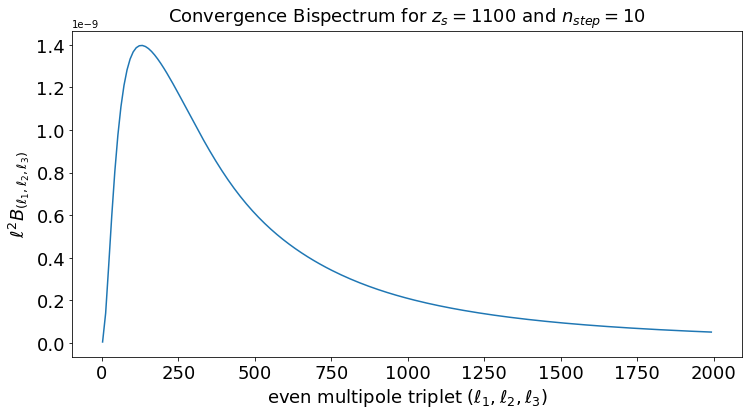

In [18]:
bls = ells**2 * Bls
finite_ells = ells[np.isfinite(bls)]
finite_bls = bls[np.isfinite(bls)]

plot_bispec_eq(finite_ells, finite_bls,
               ylabel="$\ell^2 B_{(\ell_1, \ell_2, \ell_3)}$",
               title="Convergence Bispectrum for $z_s = 1100.$ and $n_{step} = 10$")

Next steps:

- Double check the $h$ factors
- Power spectrum still looks off relative to the CCL one, so double check that -- review CAMB tutorial to make sure nothing is wrong / maybe swap out with the CCL one
- Check units in the `cumulative` function. A factor of $10^{10}$ could just be a unit offset.
    - Go through paper again and compare formulae to Python functions
    - Coefficient is being multiplied not divided.
    - Usually the little things.
- Check the $\cos\theta$ factor in the $F_2$ function and the $z_s$ and $\chi_s$. i.e. make sure the $\chi_s$ is being used where it should and the $\chi$ is being used where it should.

Message Patricia about writing outline.

In [19]:
z_s = 200.
P_k = create_pk(z_s, kmax)
chi_int, z_int = interp_chi_and_z(z_s)
chi_s = chi_int(z_s)

z_plot = 0.541
chi = chi_int(z_plot)

In [20]:
ells = np.arange(1, 2000)
ks = ells/chi

b_delta = [compute_B_delta(chi, P_k, ks[i], ks[i], ks[i], z_int) for i, _ in enumerate(ells)]

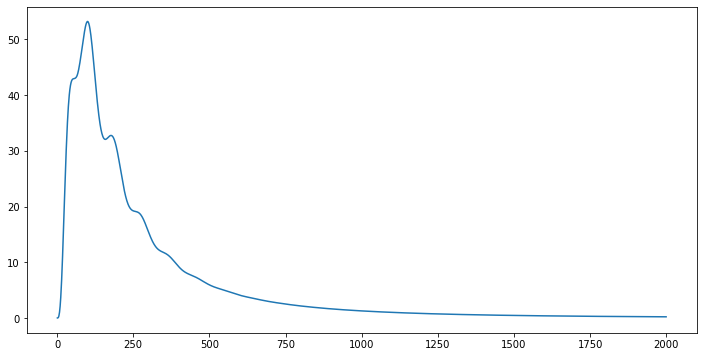

In [21]:
h = 0.6766

plt.figure(figsize=(12,6))

# plt.plot(ells, ks**(8) * b_delta)
# plt.plot(ells, ks**(-4) * b_delta)
plt.plot(ells, ks**(2) * b_delta * 10**(-5))

What to check:

- When computing the matter bispectrum pre-integral and converting to $B_{\ell}$, plot bispectrum vals (and look out for extra $\ell$ scale factors), i.e. check piece-by-piece for the `compute_convergence_bispectrum` function.
- Probable issue is a missing $k^p$ factor somewhere to look out for (since the cumulative bispectrum is exponential decaying a lot more strongly than it should)
- Could be $h$, $b$, $k$, or even the window function. Compare against current literature to check

In [22]:
def plot_pk(k, pk, pk_2, figsize=(12,6), xscale='log',
                        yscale='log', xlabel='$k\quad[Mpc^{-1}]$', 
                        ylabel='$P(k)\quad[{\\rm Mpc}]^3$', title="Power Spectrum",
                        label1="Power Spectrum 1", label2="Power Spectrum 2"):
    '''
    Plots the Power Spectrum in k-space

    Parameters
    ------------
    k : k-modes
    pk_lin : linear power spectrum P(k)
    pk_nl : non-linear power spectrum
    figsize : defaults to (12,6)
    xscale : defaults to log-scale
    yscale : defaults to log-scale
    xlabel : xlabel
    ylabel : ylabel
    title : title
    '''

    plt.figure(figsize=figsize)
    plt.plot(k, pk, 'b-', label=label1)

    if pk_2 is not None:
        plt.plot(k, pk_2, 'r-', label=label2)

    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(frameon=False, loc='upper right', fontsize=14)
    plt.show()

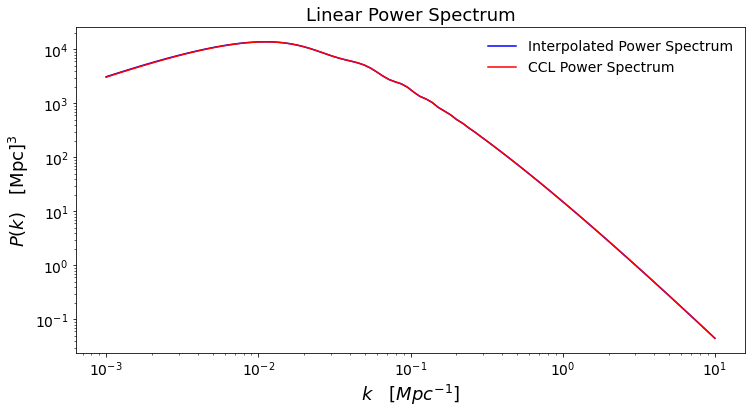

In [23]:
from helper_funcs import *

ks = np.logspace(-3, 1, 100)

# Using Planck 2018 parameters
cosmo = ccl.Cosmology(Omega_c=0.26067, Omega_b=0.049,
                            h=0.6766, n_s=0.9665, sigma8=0.8102,
                            transfer_function='boltzmann_camb')

z = 2
pk_lin_1 = P_k.P(z, ks)
pk_lin_2 = ccl.linear_matter_power(cosmo, ks, compute_scale_factor(z))

plot_pk(ks, pk_lin_1, pk_lin_2, title="Linear Power Spectrum", label1="Interpolated Power Spectrum", label2="CCL Power Spectrum")

In [24]:
def plot_bispec_eq(bls, ells,
                   figsize=(12,6), 
                   lmin=0, xlmax=None,
                   xscale='linear', yscale='linear',
                   xlabel="even multipole triplet $(\ell_1, \ell_2, \ell_3)$",
                   ylabel="$B_{(\ell_1, \ell_2, \ell_3)}$",
                   title="Bispectrum", scheme='e'):
    if scheme == 'e':
        plt.figure(figsize=figsize)
        plt.plot(ells, bls)
        plt.legend(frameon=False, loc='upper right', fontsize=14)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.ylabel(ylabel, fontsize=18)
        plt.xlabel(xlabel, fontsize=18)
        plt.title(title, fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.show()